In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

torch.manual_seed(0)
np.random.seed(0)

In [2]:
from Flow1D import CondFlow1D

In [3]:
class build_dataset(Dataset):
    
    def __init__(self, data: np.ndarray):
        self.parameters = data[:, :6].astype(np.float32)
        self.logrho = data[:, 6].astype(np.float32).reshape(-1,1)
        
    def __len__(self):
        return len(self.logrho)
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.parameters[idx]), torch.from_numpy(self.logrho[idx])

Training function

In [4]:
def train_flow_model(flow, training, validation=None, n_epochs=30, lr=1e-3, device='cpu', scheduler=None):
    
    flow.to(device)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr) # Adam optimizer

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):

        # Training loop
        
        flow.train()
        running_loss = 0.0
        for par_batch, logrho_batch in tqdm(training, desc=f"Epoch {epoch+1}/{n_epochs}"):
            par_batch = par_batch.to(device)
            logrho_batch = logrho_batch.to(device)

            optimizer.zero_grad()

            loss = -flow.log_prob(logrho_batch, par_batch).mean() # Negative log-likelihood
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * logrho_batch.size(0)

        train_losses.append(running_loss / len(training.dataset)) # epoch train loss

        # Validation loop

        if validation is not None:
            
            flow.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for par_batch, logrho_batch in validation:
                    par_batch = par_batch.to(device)
                    logrho_batch = logrho_batch.to(device)
                    
                    loss = -flow.log_prob(logrho_batch, par_batch).mean()
                    val_loss += loss.item() * logrho_batch.size(0)
                    
            val_losses.append(val_loss / len(validation.dataset)) # epoch val loss
            
        else:
            
            val_losses.append(None)

        if scheduler is not None:
            scheduler.step() # Scheduler step if provided - for adaptive lr I guess

        #print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss if valid_loader else 'N/A'}")

    return flow, train_losses, val_losses

I trained the flow using different data splitting and scalings 

# test 1

Load data and (train, validation, test) split

In [5]:
data = np.genfromtxt("data_1stbin.txt")
data_train, data_test = train_test_split(data, test_size=0.10, random_state=0)
data_train, data_validation = train_test_split(data_train, test_size=0.3, random_state=0)

Rescale my $log_{10} \, \rho$ so that data has zero mean and unit variance. Here I do not rescale the parameteres

First I fit the scaler using only the training set

In [6]:
scaler = StandardScaler()

scaler.fit(data_train[:, 6].reshape(-1, 1)) # StandardScaler wants shape (N,1)

,copy,True
,with_mean,True
,with_std,True


Then I rescale my data

In [7]:
data_train[:, 6] = scaler.transform(data_train[:, 6].reshape(-1,1)).flatten()
data_validation[:, 6]  = scaler.transform(data_validation[:, 6].reshape(-1,1)).flatten()

My data has shape (N,7) -> build_dataset divides parameters from $log_{10} \, \rho$ values

In [8]:
train = build_dataset(data_train)
validation = build_dataset(data_validation)

Prepare data for training

In [9]:
train = DataLoader(train, batch_size=512, shuffle=True)
val = DataLoader(validation, batch_size=512, shuffle=False)

Define and train the flow

In [17]:
flow = CondFlow1D(dim=6, n_layers=6, hidden=128)

trained_flow, train_loss, val_loss = train_flow_model(flow, train, validation=val, n_epochs=120, lr=5e-4, device='cpu')

Epoch 120/120: 100%|█████████████████████████████████████████████████| 1008/1008 [00:19<00:00, 50.84it/s]


It took approximately 30 mins on my laptop

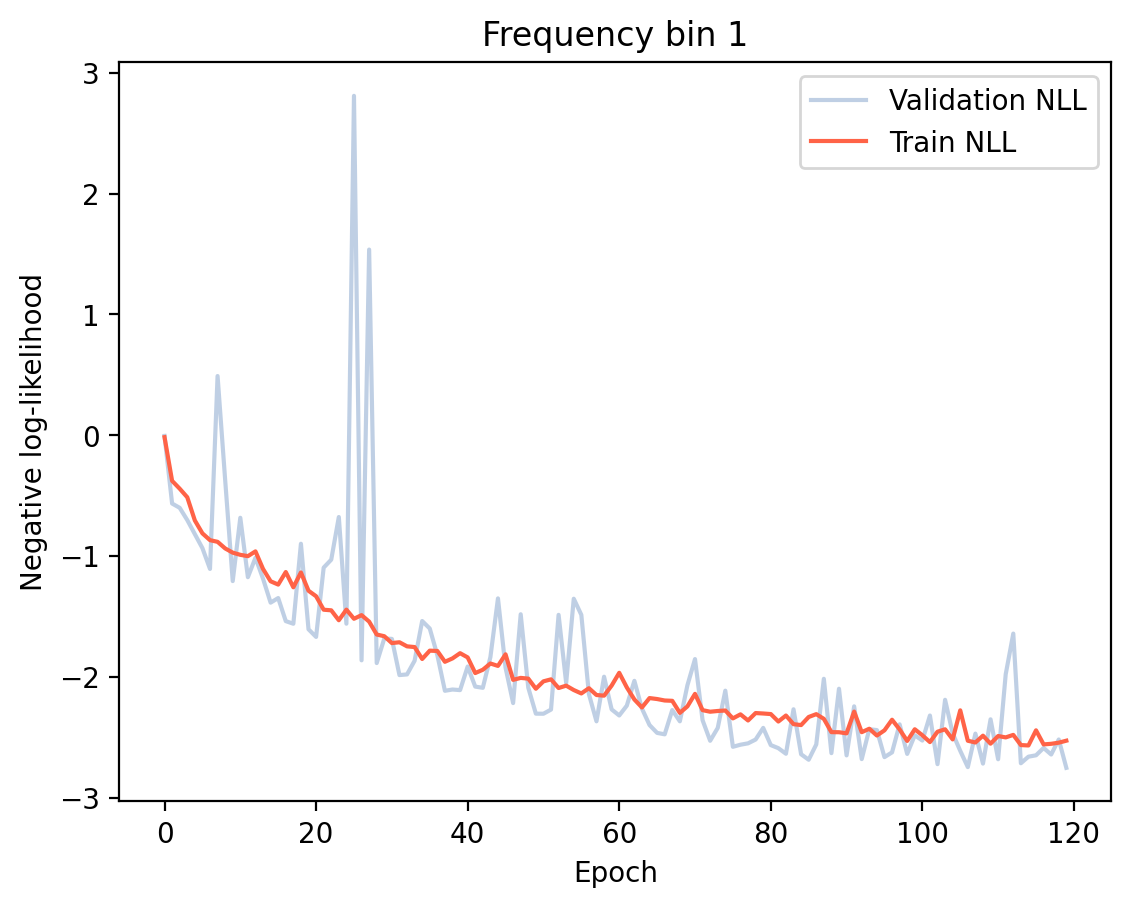

In [18]:
plt.plot(val_loss, color='lightsteelblue', alpha=0.8, label="Validation NLL")
plt.plot(train_loss, color='tomato', label="Train NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative log-likelihood")
plt.title("Frequency bin 1")
plt.legend()
plt.show()

In [ ]:
#torch.save(trained_flow.state_dict(), "Flow_bin1.pt")

# test 2

Here I keep track of the test set, I want to be able to use it later to do predictions

In [22]:
test=data[0:100000,:]

In [23]:
train=data[100000:819200,:]

In [25]:
data_train, data_validation = train_test_split(train, test_size=0.3, random_state=0)

I rescale only the data and not the parameters

In [26]:
new_scaler = StandardScaler()

new_scaler.fit(data_train[:, 6].reshape(-1, 1)) # StandardScaler wants shape (N,1)

,copy,True
,with_mean,True
,with_std,True


In [27]:
data_train[:, 6] = new_scaler.transform(data_train[:, 6].reshape(-1,1)).flatten()
data_validation[:, 6]  = new_scaler.transform(data_validation[:, 6].reshape(-1,1)).flatten()

In [28]:
train = build_dataset(data_train)
validation = build_dataset(data_validation)

In [29]:
train = DataLoader(train, batch_size=512, shuffle=True)
val = DataLoader(validation, batch_size=512, shuffle=False)

In [32]:
flow = CondFlow1D(dim=6, n_layers=6, hidden=128)

new_trained_flow, train_loss, val_loss = train_flow_model(flow, train, validation=val, n_epochs=100, lr=5e-4, device='cpu')

Epoch 100/100: 100%|███████████████████████████████████████████████████| 984/984 [00:16<00:00, 60.29it/s]


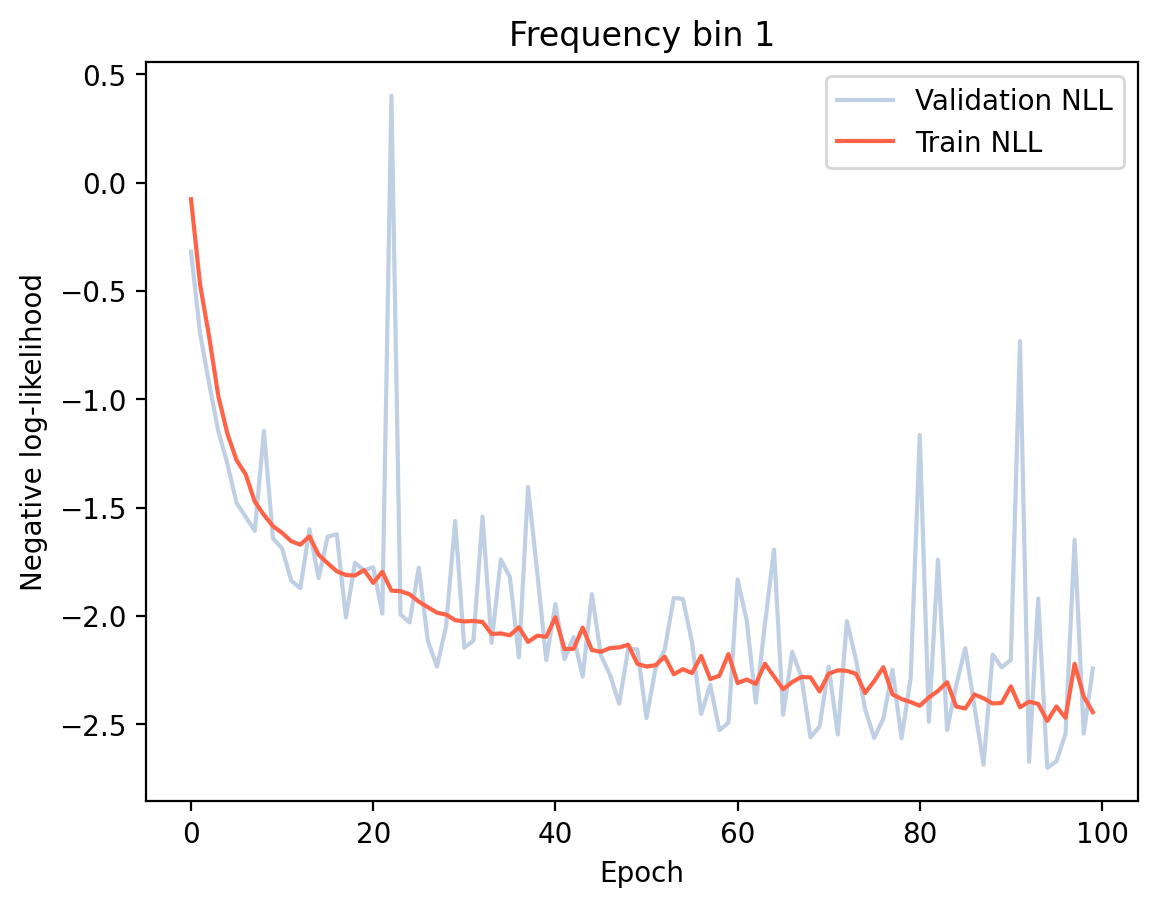

In [33]:
plt.plot(val_loss, color='lightsteelblue', alpha=0.8, label="Validation NLL")
plt.plot(train_loss, color='tomato', label="Train NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative log-likelihood")
plt.title("Frequency bin 1")
plt.legend()
plt.show()

Below: one random prediction, just to visualize the pdf.

In [66]:
theta=test[900,0:6]

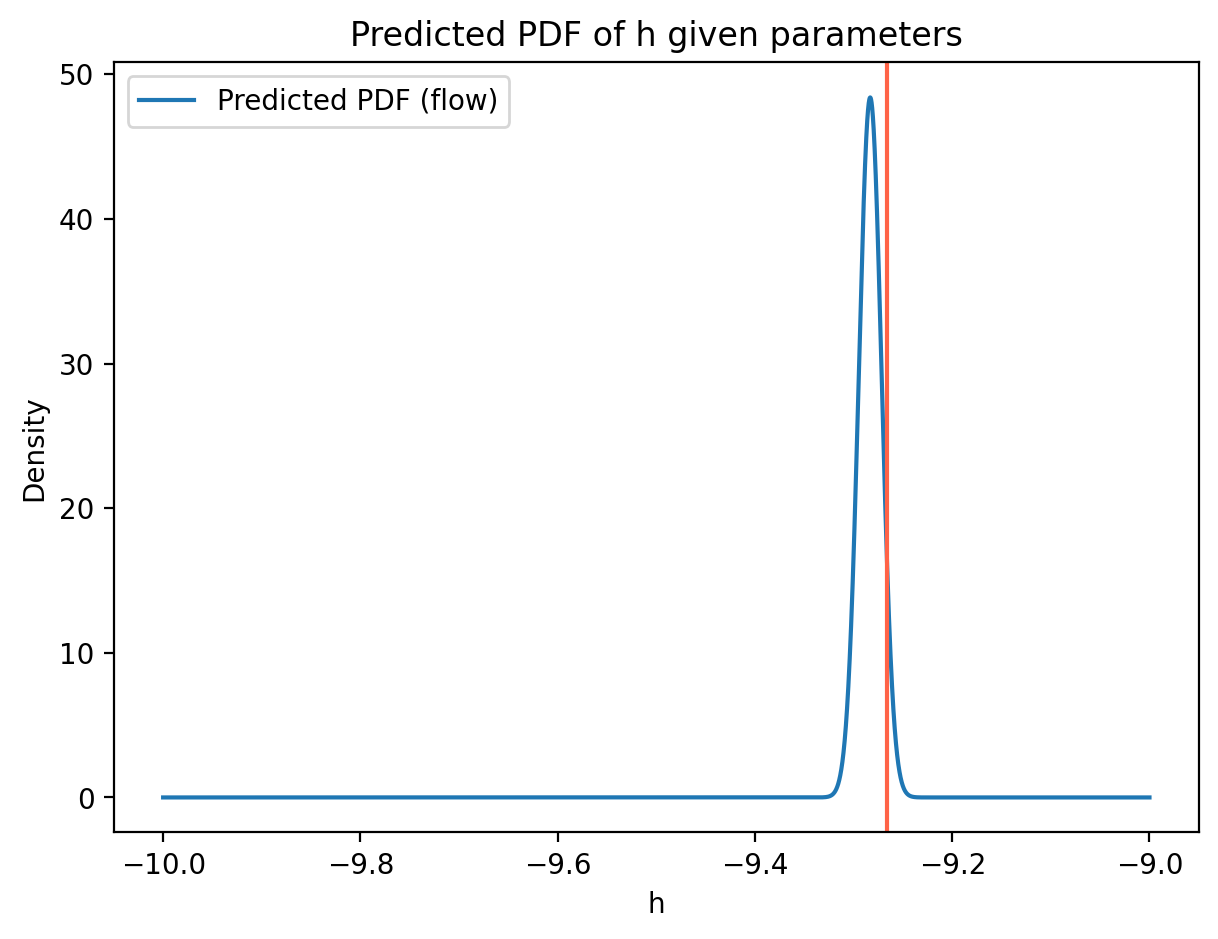

In [69]:
for theta in new_test[:,0:6]
    num_points=10000
    grid = np.linspace(-11, -3, num_points).reshape(-1,1).astype(np.float32)

    # normalize the grid
    try:
    
    grid_norm = new_scaler.transform(grid)
    
except NameError: # if the grid is already normalized
    
    grid_norm = grid

grid_tensor = torch.tensor(grid_norm, dtype=torch.float32)
theta_tensor = torch.tensor(theta, dtype=torch.float32).unsqueeze(0).repeat(num_points,1)

new_trained_flow.eval()
with torch.no_grad():
    log_p = new_trained_flow.log_prob(grid_tensor, theta_tensor)
    p = torch.exp(log_p).cpu().numpy()            # convert to PDF

# invert grid back to original scale for plotting
try:
    grid_plot = new_scaler.inverse_transform(grid_norm).flatten()
except NameError:
    grid_plot = grid.flatten()


plt.figure(figsize=(7,5))
plt.plot(grid_plot, p, label="Predicted PDF (flow)")
plt.axvline(test[900,6], color='tomato')
plt.xlabel("h")
plt.ylabel("Density")
plt.title("Predicted PDF of h given parameters")
plt.legend()
plt.show()

The red line is one of the log10(rho) realisations for that set of parameters. Also the x axis is log10(rho) not h.

Now I want to use the full test set. I predict the pdf for each set of parameters in the test set and then I take the log10(rho) for which the pdf is max (I just want to check if my predicted pdfs are centered where they should be). 

In [82]:
n_blocks = test.shape[0] // 100
reshaped = test.reshape(n_blocks, 100, 7)

# first 6 columns (same for all 100 rows)
params = reshaped[:, 0, :6]       # shape (num_blocks, 6)

# average of 7th column over the 100 rows
mean = reshaped[:, :, 6].mean(axis=1, keepdims=True)   # shape (num_blocks, 1)

# combine them
new_test = np.hstack([params, mean])

print(new_test.shape)   # (num_blocks, 7)
print(new_test[:,6])

(1000, 7)
[ -6.80952511  -7.87524988  -7.94686554  -8.09229397  -7.23349545
  -8.22677099  -5.45159234  -8.76540941  -7.20750589  -9.26565964
  -8.15635618  -7.00245836  -6.95134819 -10.93291268  -7.82734783
  -6.4028265   -8.60766915  -8.49942008  -8.71182968  -6.89734016
  -3.77664881 -10.27035196  -7.92418404  -8.59724282  -6.32742071
  -9.37913724  -9.61128206  -5.97059922  -6.19689986 -10.2641313
  -7.54760698  -7.25788499  -6.89578205  -8.37440729  -7.94277193
  -7.30146231  -4.54556943  -9.99050334  -8.00619227  -7.76594973
  -6.89173098  -9.0781985  -10.70090545  -5.87385173  -5.84121764
 -10.87268774  -7.32563459  -6.92824606  -5.91307537  -8.6663248
  -8.79696157  -7.68109449  -6.38753411  -8.94080818  -8.43032854
  -8.53974104  -7.89432204  -9.33880946  -7.10030903  -6.86432903
  -7.47532555  -9.72356136  -7.64632122  -7.01339813  -7.1124004
  -7.57092287  -9.57612027  -7.02311555  -6.65707281  -9.64693308
  -7.27852503  -7.84181385  -8.42384559  -8.4594078   -8.67458564
  -

In [85]:
num_points=10000
grid = np.linspace(-11, -3, num_points).reshape(-1,1).astype(np.float32)

# normalize the grid
try:
    
    grid_norm = new_scaler.transform(grid)
    
except NameError: # if the grid is already normalized
    
    grid_norm = grid

grid_tensor = torch.tensor(grid_norm, dtype=torch.float32)

In [86]:
predicted=[]
for theta in new_test[:,0:6]:

    theta_tensor = torch.tensor(theta, dtype=torch.float32).unsqueeze(0).repeat(num_points,1)

    new_trained_flow.eval()
    with torch.no_grad():
        log_p = new_trained_flow.log_prob(grid_tensor, theta_tensor)
        p = torch.exp(log_p).cpu().numpy()            # convert to PDF
        

    # invert grid back to original scale for plotting
        try:
            grid_plot = new_scaler.inverse_transform(grid_norm).flatten()
        except NameError:
            grid_plot = grid.flatten()
            
        predicted.append(grid_plot[p.argmax()])
        
predicted=np.array(predicted)
predicted.shape

(1000,)

In [88]:
new_test[:,6].shape

(1000,)

For each set of test parameters (6) I compute the mean  log10(rho)

I compute the (absolute value of the difference)^2 between the test mean of log10(rho) and log10(rho) for which the predicted pdfs are max

In [117]:
k=0
l=0
for i in range(1000):
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.1:
        k+=1
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.2:
        l+=1

996
999


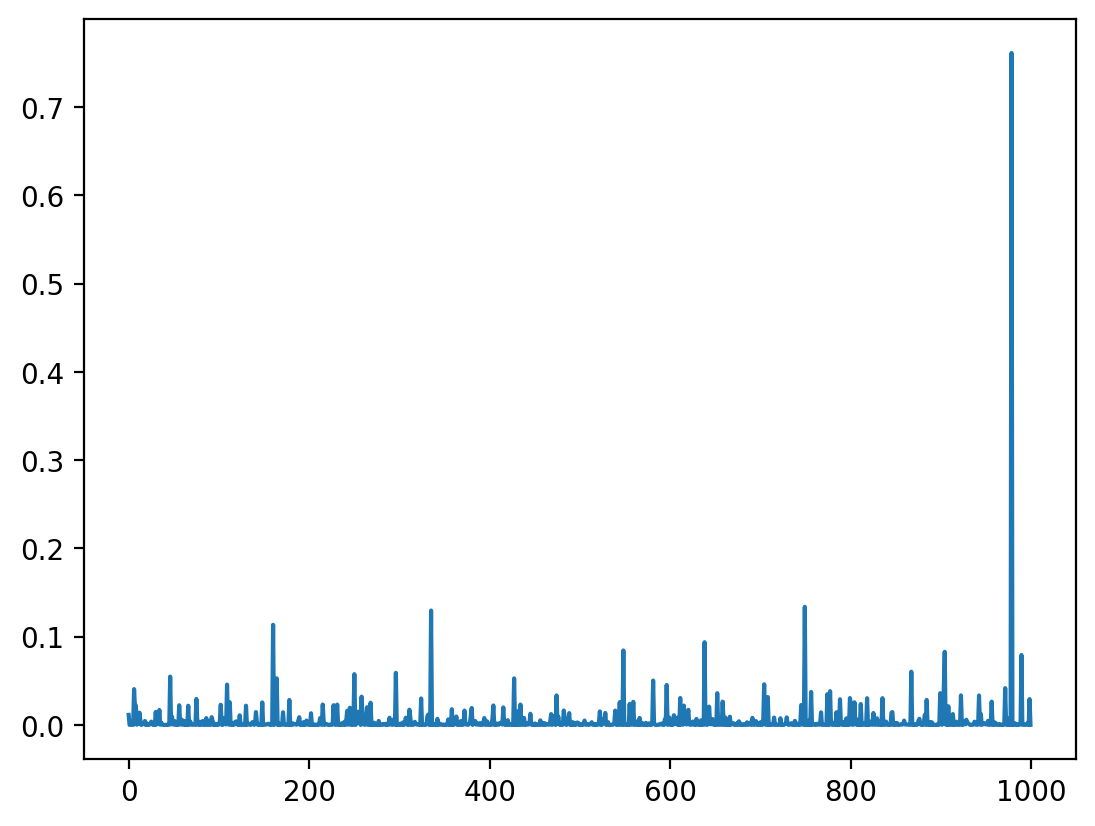

In [119]:
print(k)
print(l)
plt.plot((np.abs(new_test[:,6]-predicted))**2)

In [123]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(new_test[:, 6], predicted))

0.0050424851001092995


In [124]:
squared_errors = (predicted - new_test[:,6])**2
abs_errors = abs(predicted - new_test[:,6])

In [132]:
torch.save(new_trained_flow.state_dict(), "Flow_bin1.pt")

# test 3

Repeat the training but rescaling all of the parameters

In [5]:
data = np.genfromtxt("data_1stbin.txt")

In [6]:
test=data[0:100000,:]
train=data[100000:819200,:]
data_train, data_validation = train_test_split(train, test_size=0.2, random_state=0)

Here I use one StandardScaler for each parameter and the data separately... Then I found out I could use just one single StandardScaler for the entire dataset and I wasted a lot of time

In [8]:
scalerA = StandardScaler()
scaleralpha = StandardScaler()
scalerbeta = StandardScaler()
scalerM0 = StandardScaler()
scalerrho = StandardScaler()
scalere0 = StandardScaler()
scaler = StandardScaler()

scalerA.fit(data_train[:, 0].reshape(-1, 1)) # StandardScaler wants shape (N,1)
scaleralpha.fit(data_train[:, 1].reshape(-1, 1))
scalerbeta.fit(data_train[:, 2].reshape(-1, 1))
scalerM0.fit(data_train[:, 3].reshape(-1, 1))
scalerrho.fit(data_train[:, 4].reshape(-1, 1))
scalere0.fit(data_train[:, 5].reshape(-1, 1))
scaler.fit(data_train[:, 6].reshape(-1, 1))

,copy,True
,with_mean,True
,with_std,True


In [9]:
data_train[:, 0] = scalerA.transform(data_train[:, 0].reshape(-1,1)).flatten()
data_train[:, 1] = scaleralpha.transform(data_train[:, 1].reshape(-1,1)).flatten()
data_train[:, 2] = scalerbeta.transform(data_train[:, 2].reshape(-1,1)).flatten()
data_train[:, 3] = scalerM0.transform(data_train[:, 3].reshape(-1,1)).flatten()
data_train[:, 4] = scalerrho.transform(data_train[:, 4].reshape(-1,1)).flatten()
data_train[:, 5] = scalere0.transform(data_train[:, 5].reshape(-1,1)).flatten()
data_train[:, 6] = scaler.transform(data_train[:, 6].reshape(-1,1)).flatten()

In [10]:
data_validation[:, 0] = scalerA.transform(data_validation[:, 0].reshape(-1,1)).flatten()
data_validation[:, 1] = scaleralpha.transform(data_validation[:, 1].reshape(-1,1)).flatten()
data_validation[:, 2] = scalerbeta.transform(data_validation[:, 2].reshape(-1,1)).flatten()
data_validation[:, 3] = scalerM0.transform(data_validation[:, 3].reshape(-1,1)).flatten()
data_validation[:, 4] = scalerrho.transform(data_validation[:, 4].reshape(-1,1)).flatten()
data_validation[:, 5] = scalere0.transform(data_validation[:, 5].reshape(-1,1)).flatten()
data_validation[:, 6] = scaler.transform(data_validation[:, 6].reshape(-1,1)).flatten()

In [11]:
train = build_dataset(data_train)
validation = build_dataset(data_validation)

In [12]:
train = DataLoader(train, batch_size=512, shuffle=True)
val = DataLoader(validation, batch_size=512, shuffle=False)

In [13]:
flow = CondFlow1D(dim=6, n_layers=6, hidden=128)

trained_flow, train_loss, val_loss = train_flow_model(flow, train, validation=val, n_epochs=100, lr=5e-4, device='cpu')

Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████| 1124/1124 [00:20<00:00, 53.97it/s]


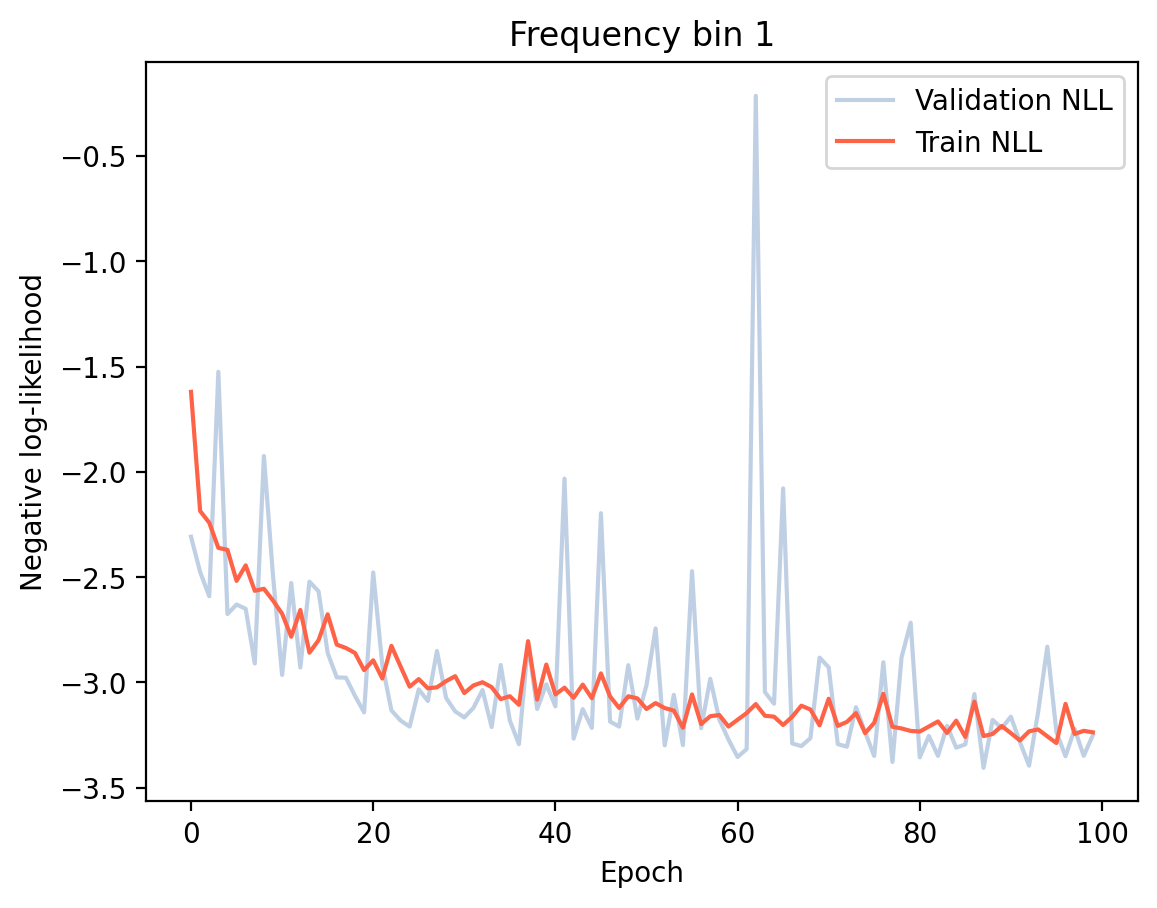

In [14]:
plt.plot(val_loss, color='lightsteelblue', alpha=0.8, label="Validation NLL")
plt.plot(train_loss, color='tomato', label="Train NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative log-likelihood")
plt.title("Frequency bin 1")
plt.legend()
plt.show()

In [15]:
n_blocks = test.shape[0] // 100
reshaped = test.reshape(n_blocks, 100, 7)

# first 6 columns (same for all 100 rows)
params = reshaped[:, 0, :6]       # shape (num_blocks, 6)

# average of 7th column over the 100 rows
mean = reshaped[:, :, 6].mean(axis=1, keepdims=True)   # shape (num_blocks, 1)

# combine them
new_test = np.hstack([params, mean])

print(new_test.shape)   # (num_blocks, 7)
print(new_test[:,6])

(1000, 7)
[ -6.80952511  -7.87524988  -7.94686554  -8.09229397  -7.23349545
  -8.22677099  -5.45159234  -8.76540941  -7.20750589  -9.26565964
  -8.15635618  -7.00245836  -6.95134819 -10.93291268  -7.82734783
  -6.4028265   -8.60766915  -8.49942008  -8.71182968  -6.89734016
  -3.77664881 -10.27035196  -7.92418404  -8.59724282  -6.32742071
  -9.37913724  -9.61128206  -5.97059922  -6.19689986 -10.2641313
  -7.54760698  -7.25788499  -6.89578205  -8.37440729  -7.94277193
  -7.30146231  -4.54556943  -9.99050334  -8.00619227  -7.76594973
  -6.89173098  -9.0781985  -10.70090545  -5.87385173  -5.84121764
 -10.87268774  -7.32563459  -6.92824606  -5.91307537  -8.6663248
  -8.79696157  -7.68109449  -6.38753411  -8.94080818  -8.43032854
  -8.53974104  -7.89432204  -9.33880946  -7.10030903  -6.86432903
  -7.47532555  -9.72356136  -7.64632122  -7.01339813  -7.1124004
  -7.57092287  -9.57612027  -7.02311555  -6.65707281  -9.64693308
  -7.27852503  -7.84181385  -8.42384559  -8.4594078   -8.67458564
  -

In [16]:
num_points=10000
grid = np.linspace(-11, -3, num_points).reshape(-1,1).astype(np.float32)

# normalize the grid
try:
    
    grid_norm = scaler.transform(grid)
    
except NameError: # if the grid is already normalized
    
    grid_norm = grid

grid_tensor = torch.tensor(grid_norm, dtype=torch.float32)

In [26]:
theta=np.zeros((1000,6))
predicted=[]

theta[:,0] = scalerA.transform(new_test[:,0].reshape(-1,1)).flatten()
theta[:,1] = scaleralpha.transform(new_test[:,1].reshape(-1,1)).flatten()
theta[:,2] = scalerbeta.transform(new_test[:,2].reshape(-1,1)).flatten()
theta[:,3] = scalerM0.transform(new_test[:,3].reshape(-1,1)).flatten()
theta[:,4] = scalerrho.transform(new_test[:,4].reshape(-1,1)).flatten()
theta[:,5] = scalere0.transform(new_test[:,5].reshape(-1,1)).flatten()

for par in theta[:,0:6]:
    
    theta_tensor = torch.tensor(par, dtype=torch.float32).unsqueeze(0).repeat(num_points,1)

    trained_flow.eval()
    
    with torch.no_grad():
        
        log_p = trained_flow.log_prob(grid_tensor, theta_tensor)
        p = torch.exp(log_p).cpu().numpy()            # convert to PDF
        

    # invert grid back to original scale for plotting
        try:
            grid_plot = scaler.inverse_transform(grid_norm).flatten()
        except NameError:
            grid_plot = grid.flatten()
            
        predicted.append(grid_plot[p.argmax()])
        
predicted=np.array(predicted)
predicted.shape

(1000,)

In [27]:
k=0
l=0
for i in range(1000):
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.1:
        k+=1
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.2:
        l+=1

999
1000


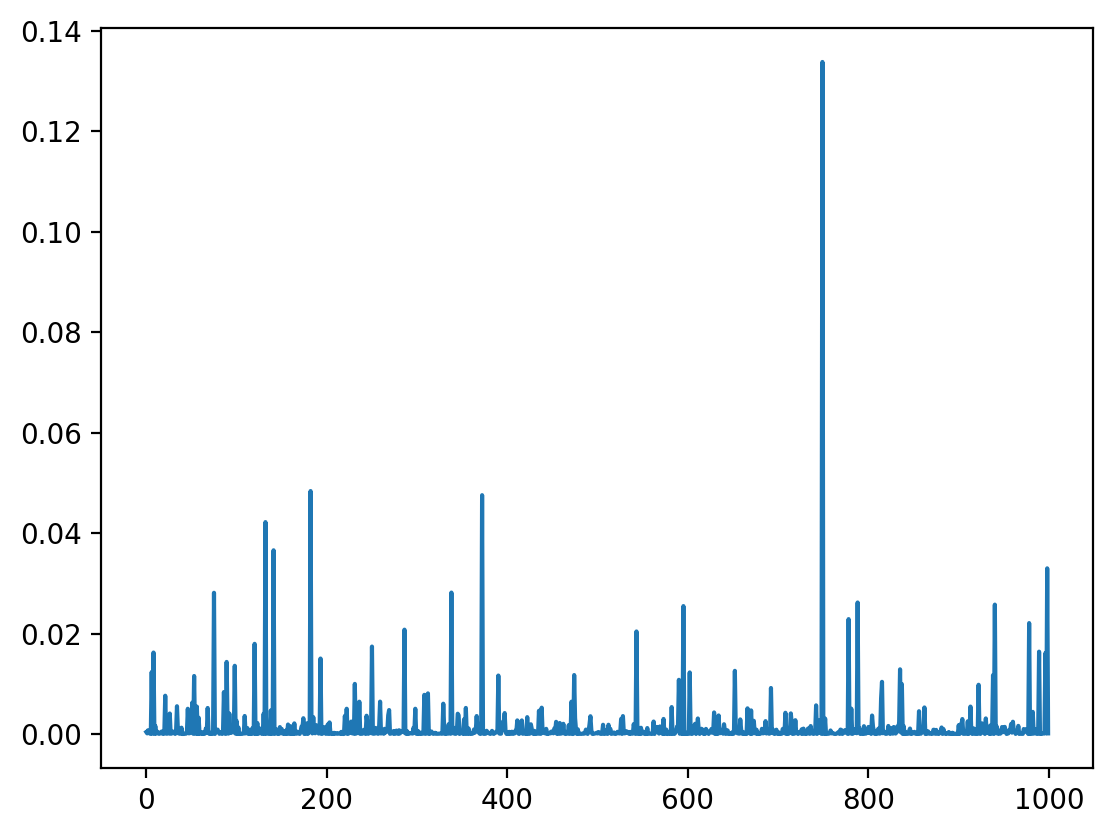

In [28]:
print(k)
print(l)
plt.plot((np.abs(new_test[:,6]-predicted))**2)

In [30]:
torch.save(trained_flow.state_dict(), "Flow_bin1.pt")

In [32]:
import joblib 

joblib.dump(scalerA, "scalerA.pkl")
joblib.dump(scaleralpha, "scaleralpha.pkl")
joblib.dump(scalerbeta, "scalerbeta.pkl")
joblib.dump(scalerM0, "scalerM0.pkl")
joblib.dump(scalerrho, "scalerrho.pkl")
joblib.dump(scalere0, "scalere0.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [33]:
#scaler = joblib.load("scaler.pkl")

# test 4

with a bigger validation set

In [34]:
test=data[0:100000,:]
train=data[100000:819200,:]
data_train, data_validation = train_test_split(train, test_size=0.4, random_state=0)

In [35]:
scalerA = StandardScaler()
scaleralpha = StandardScaler()
scalerbeta = StandardScaler()
scalerM0 = StandardScaler()
scalerrho = StandardScaler()
scalere0 = StandardScaler()
scaler = StandardScaler()

scalerA.fit(data_train[:, 0].reshape(-1, 1)) # StandardScaler wants shape (N,1)
scaleralpha.fit(data_train[:, 1].reshape(-1, 1))
scalerbeta.fit(data_train[:, 2].reshape(-1, 1))
scalerM0.fit(data_train[:, 3].reshape(-1, 1))
scalerrho.fit(data_train[:, 4].reshape(-1, 1))
scalere0.fit(data_train[:, 5].reshape(-1, 1))
scaler.fit(data_train[:, 6].reshape(-1, 1))

,copy,True
,with_mean,True
,with_std,True


In [36]:
data_train[:, 0] = scalerA.transform(data_train[:, 0].reshape(-1,1)).flatten()
data_train[:, 1] = scaleralpha.transform(data_train[:, 1].reshape(-1,1)).flatten()
data_train[:, 2] = scalerbeta.transform(data_train[:, 2].reshape(-1,1)).flatten()
data_train[:, 3] = scalerM0.transform(data_train[:, 3].reshape(-1,1)).flatten()
data_train[:, 4] = scalerrho.transform(data_train[:, 4].reshape(-1,1)).flatten()
data_train[:, 5] = scalere0.transform(data_train[:, 5].reshape(-1,1)).flatten()
data_train[:, 6] = scaler.transform(data_train[:, 6].reshape(-1,1)).flatten()

data_validation[:, 0] = scalerA.transform(data_validation[:, 0].reshape(-1,1)).flatten()
data_validation[:, 1] = scaleralpha.transform(data_validation[:, 1].reshape(-1,1)).flatten()
data_validation[:, 2] = scalerbeta.transform(data_validation[:, 2].reshape(-1,1)).flatten()
data_validation[:, 3] = scalerM0.transform(data_validation[:, 3].reshape(-1,1)).flatten()
data_validation[:, 4] = scalerrho.transform(data_validation[:, 4].reshape(-1,1)).flatten()
data_validation[:, 5] = scalere0.transform(data_validation[:, 5].reshape(-1,1)).flatten()
data_validation[:, 6] = scaler.transform(data_validation[:, 6].reshape(-1,1)).flatten()

train = build_dataset(data_train)
validation = build_dataset(data_validation)

train = DataLoader(train, batch_size=512, shuffle=True)
val = DataLoader(validation, batch_size=512, shuffle=False)

flow = CondFlow1D(dim=6, n_layers=6, hidden=128)

trained_flow1, train_loss1, val_loss1 = train_flow_model(flow, train, validation=val, n_epochs=100, lr=5e-4, device='cpu')

Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████| 843/843 [00:14<00:00, 57.22it/s]


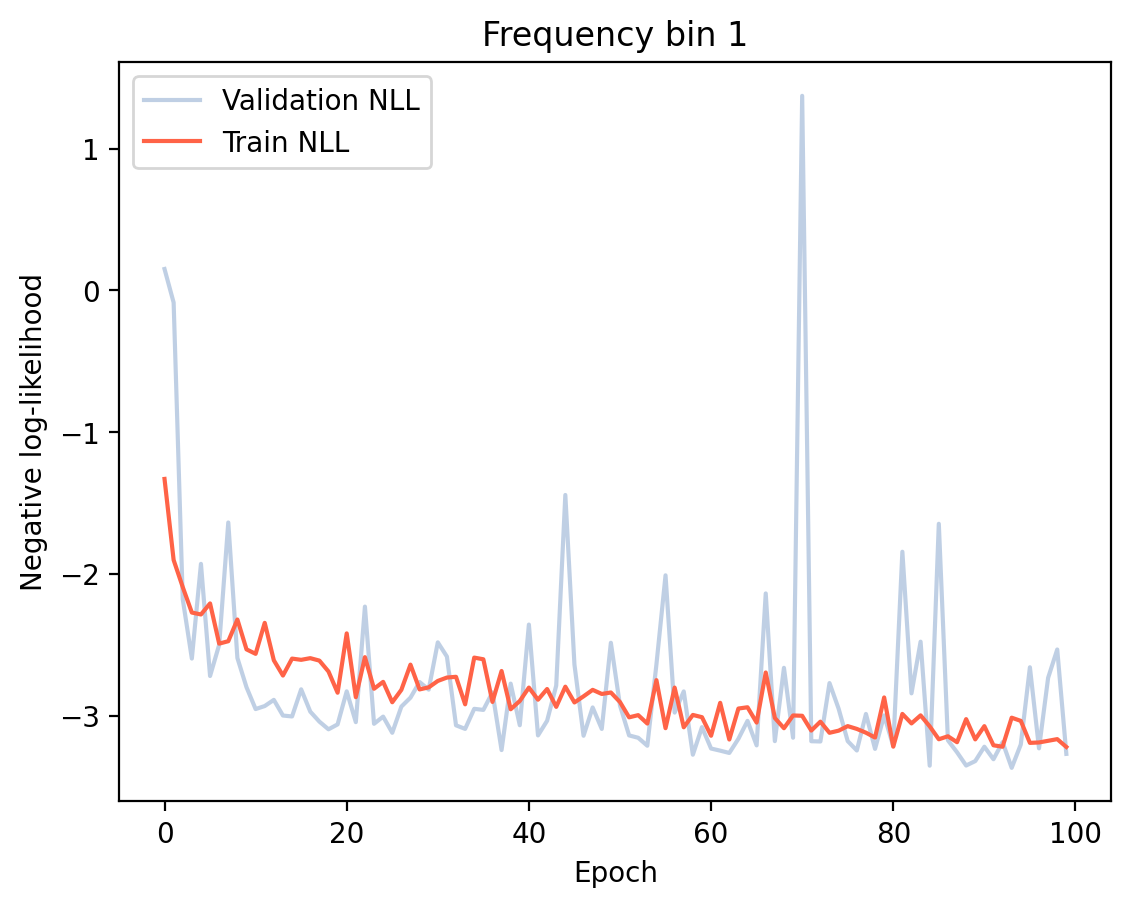

In [37]:
plt.plot(val_loss1, color='lightsteelblue', alpha=0.8, label="Validation NLL")
plt.plot(train_loss1, color='tomato', label="Train NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative log-likelihood")
plt.title("Frequency bin 1")
plt.legend()
plt.show()

In [38]:
n_blocks = test.shape[0] // 100
reshaped = test.reshape(n_blocks, 100, 7)

# first 6 columns (same for all 100 rows)
params = reshaped[:, 0, :6]       # shape (num_blocks, 6)

# average of 7th column over the 100 rows
mean = reshaped[:, :, 6].mean(axis=1, keepdims=True)   # shape (num_blocks, 1)

# combine them
new_test = np.hstack([params, mean])

print(new_test.shape)   # (num_blocks, 7)
print(new_test[:,6])

num_points=10000
grid = np.linspace(-11, -3, num_points).reshape(-1,1).astype(np.float32)

# normalize the grid
try:
    
    grid_norm = scaler.transform(grid)
    
except NameError: # if the grid is already normalized
    
    grid_norm = grid

grid_tensor = torch.tensor(grid_norm, dtype=torch.float32)

theta=np.zeros((1000,6))
predicted=[]

theta[:,0] = scalerA.transform(new_test[:,0].reshape(-1,1)).flatten()
theta[:,1] = scaleralpha.transform(new_test[:,1].reshape(-1,1)).flatten()
theta[:,2] = scalerbeta.transform(new_test[:,2].reshape(-1,1)).flatten()
theta[:,3] = scalerM0.transform(new_test[:,3].reshape(-1,1)).flatten()
theta[:,4] = scalerrho.transform(new_test[:,4].reshape(-1,1)).flatten()
theta[:,5] = scalere0.transform(new_test[:,5].reshape(-1,1)).flatten()

for par in theta[:,0:6]:
    
    theta_tensor = torch.tensor(par, dtype=torch.float32).unsqueeze(0).repeat(num_points,1)

    trained_flow.eval()
    
    with torch.no_grad():
        
        log_p = trained_flow.log_prob(grid_tensor, theta_tensor)
        p = torch.exp(log_p).cpu().numpy()            # convert to PDF
        

    # invert grid back to original scale for plotting
        try:
            grid_plot = scaler.inverse_transform(grid_norm).flatten()
        except NameError:
            grid_plot = grid.flatten()
            
        predicted.append(grid_plot[p.argmax()])
        
predicted=np.array(predicted)
predicted.shape

(1000, 7)
[ -6.80952511  -7.87524988  -7.94686554  -8.09229397  -7.23349545
  -8.22677099  -5.45159234  -8.76540941  -7.20750589  -9.26565964
  -8.15635618  -7.00245836  -6.95134819 -10.93291268  -7.82734783
  -6.4028265   -8.60766915  -8.49942008  -8.71182968  -6.89734016
  -3.77664881 -10.27035196  -7.92418404  -8.59724282  -6.32742071
  -9.37913724  -9.61128206  -5.97059922  -6.19689986 -10.2641313
  -7.54760698  -7.25788499  -6.89578205  -8.37440729  -7.94277193
  -7.30146231  -4.54556943  -9.99050334  -8.00619227  -7.76594973
  -6.89173098  -9.0781985  -10.70090545  -5.87385173  -5.84121764
 -10.87268774  -7.32563459  -6.92824606  -5.91307537  -8.6663248
  -8.79696157  -7.68109449  -6.38753411  -8.94080818  -8.43032854
  -8.53974104  -7.89432204  -9.33880946  -7.10030903  -6.86432903
  -7.47532555  -9.72356136  -7.64632122  -7.01339813  -7.1124004
  -7.57092287  -9.57612027  -7.02311555  -6.65707281  -9.64693308
  -7.27852503  -7.84181385  -8.42384559  -8.4594078   -8.67458564
  -

(1000,)

999
1000


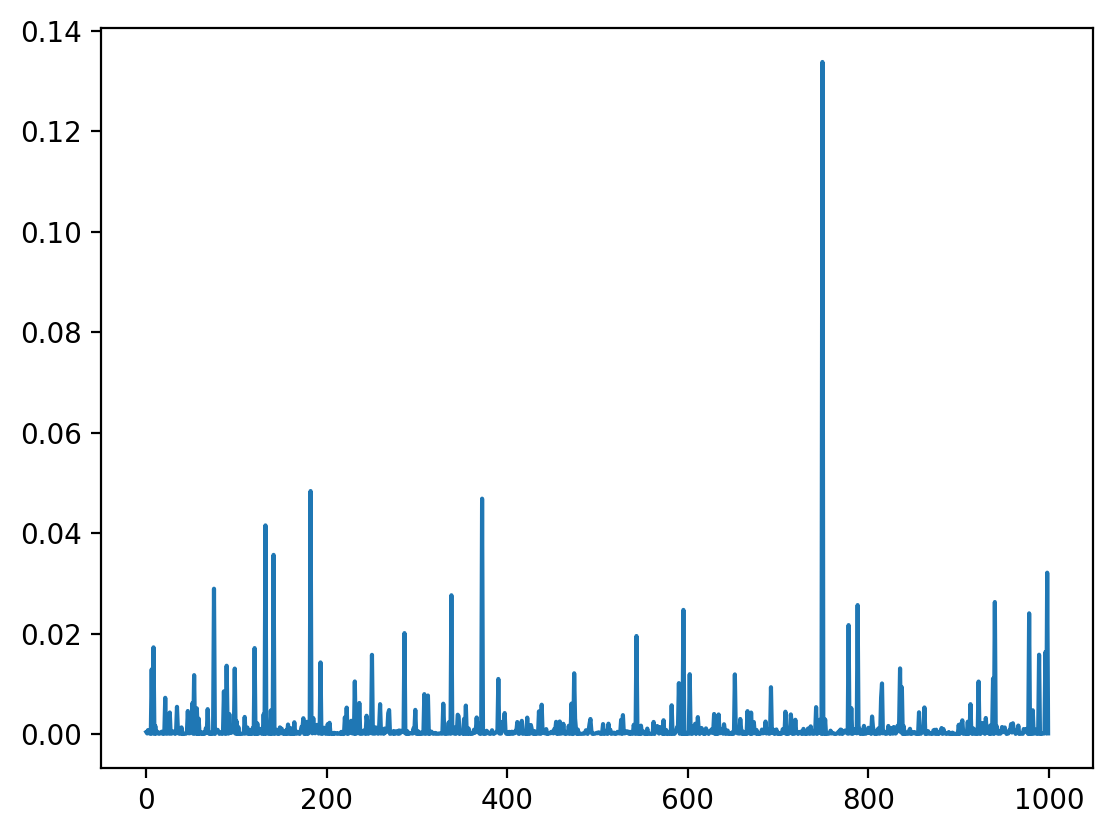

In [39]:
k=0
l=0
for i in range(1000):
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.1:
        k+=1
    if (np.abs(new_test[i,6]-predicted[i]))**2<0.2:
        l+=1

print(k)
print(l)
plt.plot((np.abs(new_test[:,6]-predicted))**2)